In [1]:
import sys
sys.path.append('../../')

In [2]:
from SynRBL.rsmi_utils import load_database, save_database

art1 = load_database('../../Data/Validation_set/artificial_data_1/mcs_based_reactions.json.gz')
art2 = load_database('../../Data/Validation_set/artificial_data_2/mcs_based_reactions.json.gz')

In [6]:
jaworski = load_database('../../Data/Validation_set/Jaworski/rule_based_reactions.json.gz')

In [12]:
jaworski[2]


{'reactions': '[H][C@@]12CC[C@@H](OC1=O)C13CCCC21CC3(C)C>>[H][C@]12CCC3C(C)(C)CC11CCC[C@@]31OC2=O',
 'id': 'complex_20',
 'reactants': '[H][C@@]12CC[C@@H](OC1=O)C13CCCC21CC3(C)C',
 'products': '[H][C@]12CCC3C(C)(C)CC11CCC[C@@]31OC2=O.O',
 'R-id': 'Jaworski_20',
 'carbon_balance_check': 'balanced',
 'Unbalance': 'Products',
 'Diff_formula': {'O': 1, 'H': 2, 'Q': 0},
 'new_reaction': '[H][C@@]12CC[C@@H](OC1=O)C13CCCC21CC3(C)C>>[H][C@]12CCC3C(C)(C)CC11CCC[C@@]31OC2=O.O'}

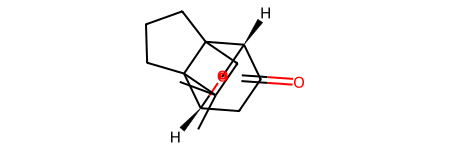

In [19]:
from rdkit import Chem
Chem.MolFromSmiles('[H][C@@]12CC[C@@H](OC1=O)C13CCCC21CC3(C)C')

In [15]:
from SynRBL.SynProcessor import RSMIProcessing, RSMIDecomposer, RSMIComparator, BothSideReact, CheckCarbonBalance

from SynRBL.SynRuleImputer import SyntheticRuleImputer
from SynRBL.SynRuleImputer.synthetic_rule_constraint import RuleConstraint
from SynRBL.rsmi_utils import save_database, load_database, filter_data, extract_results_by_key, get_random_samples_by_key
from SynRBL.SynVis import ReactionVisualizer
from rdkit import  RDLogger
import rdkit
import matplotlib
from collections import defaultdict
import os
import pandas as pd

In [33]:
df = pd.read_csv('../../Data/Validation_set/Jaworski.csv')
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Save solved and unsolved reactions
# save_dir = '../../Data/Validation_set/Jaworski'
# if not save_dir.exists():
#     os.mkdir(save_dir)

# 1. process data
process = RSMIProcessing(data=df, rsmi_col='reactions', parallel=True, n_jobs=4, data_name='Jaworski',
                            save_json =False, save_path_name=None)
reactions = process.data_splitter().to_dict('records')


# 2. check carbon balance
check = CheckCarbonBalance(reactions, rsmi_col='reactions', symbol='>>', atom_type='C', n_jobs=4)
reactions = check.check_carbon_balance()
rules_based = [reactions[key] for key, value in enumerate(reactions) if value['carbon_balance_check'] == 'balanced']
mcs_based = [reactions[key] for key, value in enumerate(reactions) if value['carbon_balance_check'] != 'balanced']

# 3. decompose into dict of symbols
decompose = RSMIDecomposer(smiles=None, data=rules_based, reactant_col='reactants', product_col='products', parallel=True, n_jobs=4, verbose=1)
react_dict, product_dict = decompose.data_decomposer()

# 4. compare dict and check balance
comp = RSMIComparator(reactants=react_dict, products=product_dict, n_jobs=4)
unbalance, diff_formula = comp.run_parallel(reactants=react_dict, products=product_dict)

# 5. solve the both side reaction
both_side = BothSideReact(react_dict, product_dict, unbalance, diff_formula)
diff_formula, unbalance= both_side.fit()


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.2s
[11:40:08] WARNING: not removing hydrogen atom without neighbors
[11:40:08] WARNING: not removing hydrogen atom without neighbors
[11:40:08] WARNING: not removing hydrogen atom without neighbors
[11:40:08] WARNING: not removing hydrogen atom without neighbors
[11:40:08] WARNING: not removing hydrogen atom without neighbors
[11:40:08] WARNING: not removing hydrogen atom without neighbors
[11:40:08] WARNING: not removing hydrogen atom without neighbors
[11:40:08] WARNING: not removing hydrogen atom without neighbors
[11:40:08] WARNING: not removing hydrogen atom without neighbors
[11:40:08] WARNING: not removing hydrogen atom without neighbors
[Parallel(n_jobs=4)]: Done 638 out of 638 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.0s
[11:40:0

In [34]:
rules_based[18]

{'reactions': '[H][C@@]12CC[C@@H](OC1=O)C13CCCC21CC3(C)C>>[H][C@]12CCC3C(C)(C)CC11CCC[C@@]31OC2=O',
 'id': 'complex_20',
 'reactants': '[H][C@@]12CC[C@@H](OC1=O)C13CCCC21CC3(C)C',
 'products': '[H][C@]12CCC3C(C)(C)CC11CCC[C@@]31OC2=O',
 'R-id': 'Jaworski_20',
 'carbon_balance_check': 'balanced'}

In [37]:
reactions_clean = pd.concat([pd.DataFrame(rules_based), pd.DataFrame([unbalance]).T.rename(columns={0: 'Unbalance'}),
                                pd.DataFrame([diff_formula]).T.rename(columns={0: 'Diff_formula'})], axis=1).to_dict(orient='records')

In [38]:
reactions_clean[18]

{'reactions': '[H][C@@]12CC[C@@H](OC1=O)C13CCCC21CC3(C)C>>[H][C@]12CCC3C(C)(C)CC11CCC[C@@]31OC2=O',
 'id': 'complex_20',
 'reactants': '[H][C@@]12CC[C@@H](OC1=O)C13CCCC21CC3(C)C',
 'products': '[H][C@]12CCC3C(C)(C)CC11CCC[C@@]31OC2=O',
 'R-id': 'Jaworski_20',
 'carbon_balance_check': 'balanced',
 'Unbalance': 'Balance',
 'Diff_formula': {}}

In [26]:
len(rules_based)

521

In [30]:
[key for key, value in enumerate(rules_based) if value['id'] == 'complex_20']

[18]

In [35]:
unbalance[18]

'Balance'

In [36]:
diff_formula[18]

{}

In [27]:
len(diff_formula)

521

In [28]:
len(unbalance)

521

In [24]:
[reactions_clean[key] for key, value in enumerate(reactions) if value['id'] == 'complex_20']

[{'reactions': 'CC(=C)[C@@H](O)[C@@H](O)C(C)=C.CC(C)=O>>CC(=C)[C@@H]1OC(C)(C)C[C@]1(C)C=O',
  'id': 'complex_22',
  'reactants': 'CC(=C)[C@@H](O)[C@@H](O)C(C)=C.CC(C)=O',
  'products': 'CC(=C)[C@@H]1OC(C)(C)C[C@]1(C)C=O',
  'R-id': 'Jaworski_22',
  'carbon_balance_check': 'balanced',
  'Unbalance': 'Products',
  'Diff_formula': {'O': 1, 'H': 2}}]

In [18]:
reactions_clean

[{'reactions': 'C=CCOc1ccccc1>>Oc1ccccc1CC=C',
  'id': 'complex_0',
  'reactants': 'C=CCOc1ccccc1',
  'products': 'Oc1ccccc1CC=C',
  'R-id': 'Jaworski_0',
  'carbon_balance_check': 'balanced',
  'Unbalance': 'Balance',
  'Diff_formula': {}},
 {'reactions': 'C\\C=C\\CC\\C=C\\C>>CC(C=C)C(C)C=C',
  'id': 'complex_1',
  'reactants': 'C\\C=C\\CC\\C=C\\C',
  'products': 'CC(C=C)C(C)C=C',
  'R-id': 'Jaworski_1',
  'carbon_balance_check': 'balanced',
  'Unbalance': 'Balance',
  'Diff_formula': {}},
 {'reactions': 'CCCC[Sn](CCCC)(CCCC)CO[C@@H]1C[C@H](C=C1)N(CC=C)C(=O)OC(C)(C)C>>CC(C)(C)OC(=O)N(CC=C)[C@@H]1CC=C[C@H]1CO.CCCC[SnH](CCCC)CCCC',
  'id': 'complex_2',
  'reactants': 'CCCC[Sn](CCCC)(CCCC)CO[C@@H]1C[C@H](C=C1)N(CC=C)C(=O)OC(C)(C)C',
  'products': 'CC(C)(C)OC(=O)N(CC=C)[C@@H]1CC=C[C@H]1CO.CCCC[SnH](CCCC)CCCC',
  'R-id': 'Jaworski_2',
  'carbon_balance_check': 'balanced',
  'Unbalance': 'Reactants',
  'Diff_formula': {'H': 2}},
 {'reactions': 'CC(C)C1=C/C=C(C)/CC\\C=C(C)\\CC[C@@H](OC\\1)C(

In [ ]:


save_database(reactions_clean, save_dir / 'reactions_clean.json.gz')
if rules_extension:
    rules = load_database(root_dir / 'Data/Rules/rules_manager_extension.json.gz')
else:
    rules = load_database(root_dir / 'Data/Rules/rules_manager.json.gz')

# 6. Filter data based on specified criteria
balance_reactions = filter_data(reactions_clean, unbalance_values=['Balance'], 
                                formula_key='Diff_formula', element_key=None, min_count=0, max_count=0)
print('Number of Balanced Reactions:', len(balance_reactions))

unbalance_reactions = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], 
                                formula_key='Diff_formula', element_key=None, min_count=0, max_count=0)
print('Number of Unbalanced Reactions in one side:', len(unbalance_reactions))

both_side_reactions = filter_data(reactions_clean, unbalance_values=['Both'], 
                                    formula_key='Diff_formula', element_key=None, min_count=0, max_count=0)
print('Number of Both sides Unbalanced Reactions:', len(both_side_reactions))

# 7. Rule-based imputeration - Configure RDKit logging
lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)
RDLogger.DisableLog('rdApp.info') 
rdkit.RDLogger.DisableLog('rdApp.*')

# Initialize SyntheticRuleImputer and perform parallel imputation
imp = SyntheticRuleImputer(rule_dict=rules, select='all', ranking='ion_priority')
expected_result = imp.parallel_impute(unbalance_reactions)

# Extract solved and unsolved results
solve, unsolve = extract_results_by_key(expected_result)
print('Solved:', len(solve))
print('Unsolved in rules based method:', len(unsolve))

unsolve = both_side_reactions + unsolve
print('Total unsolved:', len(unsolve))


# 8. Handle uncertainty in imputation
constrain = RuleConstraint(solve, ban_atoms=['[O].[O]', 'F-F', 'Cl-Cl', 'Br-Br', 'I-I', 'Cl-Br', 'Cl-I', 'Br-I'])
certain_reactions, uncertain_reactions = constrain.fit()

id_uncertain = [entry['R-id'] for entry in uncertain_reactions]
new_uncertain_reactions = [entry for entry in reactions_clean if entry['R-id'] in id_uncertain]

unsolve = unsolve + new_uncertain_reactions
mcs_based = mcs_based+unsolve

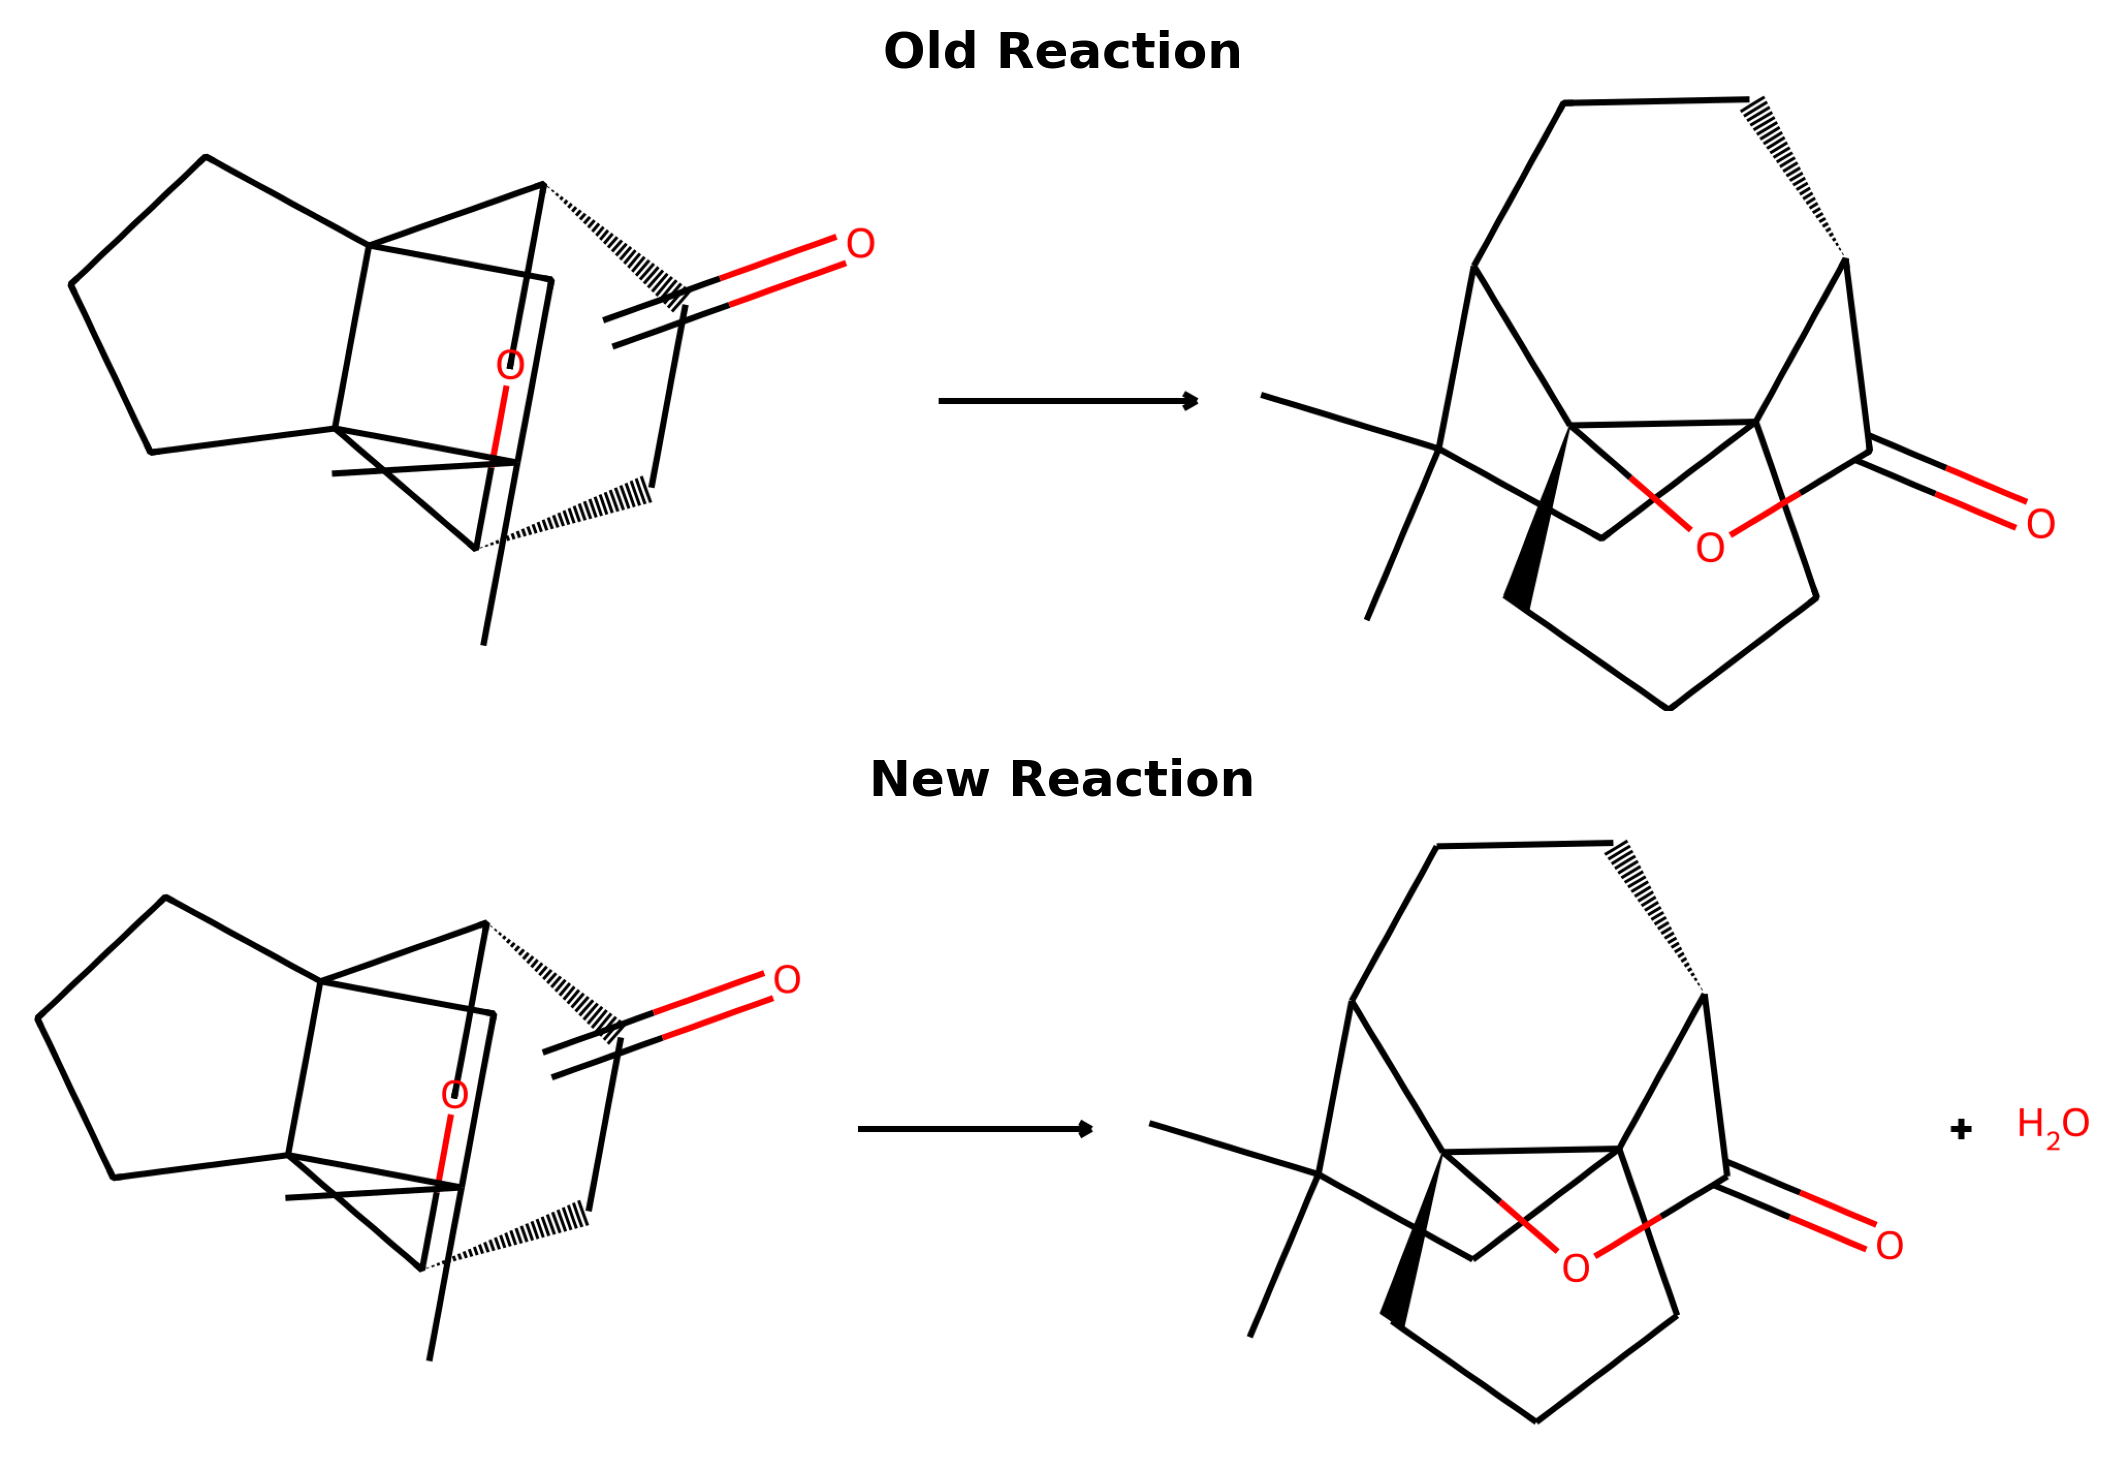

In [11]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(jaworski[2], 'reactions', 'new_reaction', compare=True)